# False Positive Brand Classifier - Model Selection & Tuning

This notebook performs model selection and hyperparameter tuning for the FP classifier. It loads the feature transformer created in fp1_EDA_FE.ipynb and focuses on finding the optimal model.

## Objective
Select the best classification model and tune hyperparameters to maximize F2 score (recall-weighted).

**Important:** This notebook uses ONLY training and validation data. Test set evaluation, threshold optimization, and deployment are performed in fp3_model_evaluation_deployment.ipynb.

## Contents
1. [Setup](#setup)
2. [Data Loading & Split](#1-data-loading--split)
3. [Feature Transformation](#2-feature-transformation)
4. [Baseline Model Comparison](#3-baseline-model-comparison)
5. [Hyperparameter Tuning](#4-hyperparameter-tuning)
6. [Overfitting Analysis](#5-overfitting-analysis)
7. [Final Model Selection](#6-final-model-selection)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns

# Sklearn imports
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import load_jsonl_data, split_train_val_test
from src.fp1_nb.preprocessing import clean_text, create_text_features
from src.fp1_nb.feature_transformer import FPFeatureTransformer
from src.fp1_nb.modeling import (
    create_search_object,
    tune_with_logging,
    get_best_params_summary,
    get_best_model,
    compare_models,
    evaluate_model,
)
from src.fp2_nb.overfitting_analysis import (
    analyze_cv_train_val_gap,
    analyze_iteration_performance,
    get_gap_summary,
)

# Settings
warnings.filterwarnings('ignore')
# Suppress sklearn parallel warning (internal sklearn issue, not actionable)
warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TARGET_COL = 'is_sportswear'
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

print("Setup complete!")

Setup complete!


## 1. Data Loading & Split

Load data and apply identical preprocessing and split as fp1 to ensure consistency.

In [2]:
# Load the FP training data (same as fp1)
df = load_jsonl_data(DATA_PATH)

# Create combined text features (identical to fp1)
# This ensures we use the same preprocessing
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    clean_func=clean_text
)

print(f"\nText features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

Loaded 993 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 7.04 MB

Text features created!
Sample:
mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners tweaking...


In [3]:
# Split with stratification (identical to fp1 - same random_state ensures identical splits)
train_df, val_df, test_df = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

TRAIN/VALIDATION/TEST SPLIT

Total samples: 993

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      595 (59.9%)
  Validation: 199 (20.0%)
  Test:       199 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 86.2%, 0: 13.8%
  Val: 1: 85.9%, 0: 14.1%
  Test: 1: 86.4%, 0: 13.6%


## 2. Feature Transformation

Load the fitted feature transformer from fp1 and transform all splits.

In [4]:
# Load the fitted feature transformer from fp1
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
transformer = joblib.load(transformer_path)

# Load the transformer config
config_path = MODELS_DIR / 'fp_feature_config.json'
with open(config_path) as f:
    transformer_config = json.load(f)

print(f"Loaded transformer: {transformer}")
print(f"\nTransformer config:")
for key, value in transformer_config.items():
    print(f"  {key}: {value}")

Loaded transformer: FPFeatureTransformer(method='sentence_transformer_ner', max_features=10000, fitted=True)

Transformer config:
  method: sentence_transformer_ner
  max_features: 10000
  ngram_range: [1, 2]
  min_df: 2
  max_df: 0.95
  sublinear_tf: True
  norm: l2
  char_ngram_range: [3, 5]
  char_max_features: 5000
  lsa_n_components: 100
  context_window_words: 20
  doc2vec_vector_size: 100
  doc2vec_min_count: 2
  doc2vec_epochs: 40
  doc2vec_dm: 1
  doc2vec_window: 4
  sentence_model_name: all-MiniLM-L6-v2
  include_vocab_features: True
  vocab_window_size: 15
  proximity_window_size: 20
  random_state: 42


In [5]:
# Transform train and validation splits using the fitted transformer
# NOTE: Test data is NOT used in this notebook - final evaluation is done in fp3
X_train = transformer.transform(train_df['text_features'])
X_val = transformer.transform(val_df['text_features'])

# Extract targets
y_train = train_df[TARGET_COL].values
y_val = val_df[TARGET_COL].values

# Combine train+val for hyperparameter tuning (CV will create internal train/val splits)
if sp.issparse(X_train):
    X_trainval = sp.vstack([X_train, X_val])
else:
    X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

print(f"Feature dimensionality: {X_train.shape[1]}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_trainval shape: {X_trainval.shape} (for hyperparameter tuning)")
print(f"\nNote: Test data reserved for final evaluation in fp3 notebook")

Feature dimensionality: 390
X_train shape: (595, 390)
X_val shape: (199, 390)
X_trainval shape: (794, 390) (for hyperparameter tuning)

Note: Test data reserved for final evaluation in fp3 notebook


## 3. Baseline Model Comparison

Train and evaluate multiple classifiers on the transformed features to identify the best performing models for hyperparameter tuning.

In [6]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {N_FOLDS}-fold stratified CV")

# F2 scorer (weights recall 2x higher than precision)
f2_scorer = make_scorer(fbeta_score, beta=2)

Using 3-fold stratified CV


In [7]:
# Define baseline models
# Note: MultinomialNB not included as it requires non-negative features
# (sentence transformer embeddings contain negative values)
baseline_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),
    'Linear SVM': CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=RANDOM_STATE, class_weight='balanced'),
        cv=3
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    ),
    'HistGradientBoosting': HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=5,
        class_weight='balanced',
        random_state=RANDOM_STATE,
    ),
}

In [8]:
# Train and evaluate baseline models
baseline_results = []

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    metrics = evaluate_model(
        model, X_val, y_val,
        model_name=name,
        dataset_name='Validation',
        verbose=True,
        plot=False
    )
    
    # Add F2 score to metrics (recall-weighted)
    y_pred = model.predict(X_val)
    metrics['f2'] = fbeta_score(y_val, y_pred, beta=2)
    print(f"  F2 Score:  {metrics['f2']:.4f} (recall-weighted)")
    
    baseline_results.append(metrics)


Training Logistic Regression...

MODEL EVALUATION: Logistic Regression on Validation

Classification Metrics:
  Accuracy:  0.9246
  Precision: 1.0000
  Recall:    0.9123
  F1 Score:  0.9541
  ROC-AUC:   0.9628
  PR-AUC:    0.9943

Confusion Matrix:
  TN: 28  FP: 0
  FN: 15  TP: 156

                precision    recall  f1-score   support

Not Sportswear       0.65      1.00      0.79        28
    Sportswear       1.00      0.91      0.95       171

      accuracy                           0.92       199
     macro avg       0.83      0.96      0.87       199
  weighted avg       0.95      0.92      0.93       199

  F2 Score:  0.9286 (recall-weighted)

Training Linear SVM...

MODEL EVALUATION: Linear SVM on Validation

Classification Metrics:
  Accuracy:  0.9095
  Precision: 0.9422
  Recall:    0.9532
  F1 Score:  0.9477
  ROC-AUC:   0.9609
  PR-AUC:    0.9940

Confusion Matrix:
  TN: 18  FP: 10
  FN: 8  TP: 163

                precision    recall  f1-score   support

Not Sportswear


Baseline Model Comparison (Validation Set)
                          f2  recall  precision      f1  accuracy  pr_auc
model_name                                                               
Logistic Regression   0.9286  0.9123     1.0000  0.9541    0.9246  0.9943
Linear SVM            0.9510  0.9532     0.9422  0.9477    0.9095  0.9940
Random Forest         0.9725  0.9942     0.8947  0.9418    0.8945  0.9941
HistGradientBoosting  0.9474  0.9474     0.9474  0.9474    0.9095  0.9925

Figure saved to images/fp_baseline_comparison.png


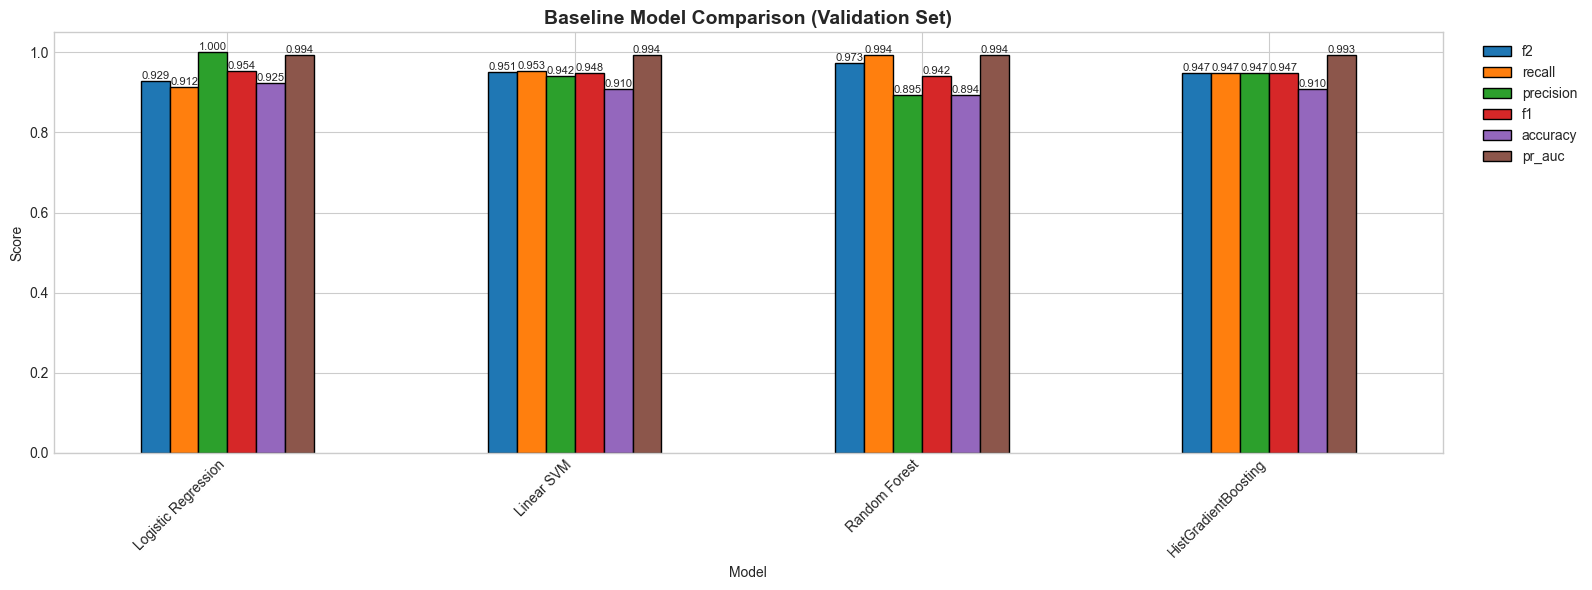

In [9]:
# Compare baseline models (with F2 as primary metric)
baseline_comparison = compare_models(
    baseline_results,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Baseline Model Comparison (Validation Set)',
    save_path='images/fp_baseline_comparison.png'
)

## 4. Hyperparameter Tuning

Tune the top-performing baseline models using cross-validation on train+val combined (80% of data). The test set remains completely held out for final evaluation.

### 4.1 Logistic Regression Tuning

In [10]:
# Logistic Regression parameter grid
# Simplified based on prior tuning: C=0.01-0.1 with class_weight=None works best
# L1/L2 penalty makes no difference at low C, so using l2 (simpler)
lr_param_grid = {
    'C': [0.01, 0.1],
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # faster than saga for l2
    'class_weight': [None],
}

lr_search = create_search_object(
    search_type='grid',
    estimator=LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    param_grid=lr_param_grid,
    cv=cv,
    refit='f2'
)

lr_search, lr_log, lr_csv = tune_with_logging(
    lr_search, X_trainval, y_trainval,
    model_name='logistic_regression'
)


HYPERPARAMETER TUNING: logistic_regression
Total parameter combinations: 2
Cross-validation folds: 3
Total fits: 6
Log file: models/logs/logistic_regression_20251221_212539.log

Tuning complete!
Best score (f2): 0.9688
Results saved to: models/logs/logistic_regression_20251221_212539_cv_results.csv


### 4.2 Random Forest Tuning

In [11]:
# Random Forest parameter grid
# Simplified based on prior tuning:
# - n_estimators=200 dominates top runs
# - max_depth=20/None perform similarly (removing 10)
# - min_samples_leaf=1 dominates (removing 2)
# - Both class_weight options work well
rf_param_grid = {
    'n_estimators': [200],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced', 'balanced_subsample'],
}

rf_search = create_search_object(
    search_type='grid',
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv,
    refit='f2'
)

rf_search, rf_log, rf_csv = tune_with_logging(
    rf_search, X_trainval, y_trainval,
    model_name='random_forest'
)


HYPERPARAMETER TUNING: random_forest
Total parameter combinations: 8
Cross-validation folds: 3
Total fits: 24
Log file: models/logs/random_forest_20251221_212548.log

Tuning complete!
Best score (f2): 0.9734
Results saved to: models/logs/random_forest_20251221_212548_cv_results.csv


### 4.3 HistGradientBoosting Tuning

In [12]:
# HistGradientBoosting parameter grid
# Simplified based on prior tuning:
# - max_depth=5 clearly outperforms 3 and None
# - learning_rate=0.1 dominates top runs
# - min_samples_leaf=5 dominates (removing 20)
# - l2_regularization=0.0 is slightly better
# - Keeping max_iter variation to check convergence
hgb_param_grid = {
    'max_iter': [100, 200],
    'learning_rate': [0.1],
    'max_depth': [5],
    'min_samples_leaf': [5],
    'l2_regularization': [0.0],
    'class_weight': ['balanced'],
}

hgb_search = create_search_object(
    search_type='grid',
    estimator=HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=hgb_param_grid,
    cv=cv,
    refit='f2'
)

hgb_search, hgb_log, hgb_csv = tune_with_logging(
    hgb_search, X_trainval, y_trainval,
    model_name='hist_gradient_boosting'
)


HYPERPARAMETER TUNING: hist_gradient_boosting
Total parameter combinations: 2
Cross-validation folds: 3
Total fits: 6
Log file: models/logs/hist_gradient_boosting_20251221_212612.log

Tuning complete!
Best score (f2): 0.9588
Results saved to: models/logs/hist_gradient_boosting_20251221_212612_cv_results.csv


### 4.4 Compare Tuned Models (CV Performance)

Compare models based on their cross-validation F2 scores. Model selection is based on CV performance, not test set performance.

In [13]:
# Compare tuned models based on CV performance
tuned_models = {
    'LR_tuned': lr_search,
    'RF_tuned': rf_search,
    'HGB_tuned': hgb_search,
}

# Extract CV metrics for comparison
cv_comparison_data = []
for name, search in tuned_models.items():
    best_idx = search.best_index_
    cv_results = search.cv_results_
    
    metrics = {
        'model_name': name,
        'f2': cv_results['mean_test_f2'][best_idx],
        'recall': cv_results['mean_test_recall'][best_idx],
        'precision': cv_results['mean_test_precision'][best_idx],
        'f1': cv_results['mean_test_f1'][best_idx],
        'accuracy': cv_results['mean_test_accuracy'][best_idx],
        'pr_auc': cv_results['mean_test_average_precision'][best_idx],
    }
    cv_comparison_data.append(metrics)
    
    print(f"{name}: CV F2 = {metrics['f2']:.4f} (+/- {cv_results['std_test_f2'][best_idx]:.4f}), Recall = {metrics['recall']:.4f}, Precision = {metrics['precision']:.4f}")

LR_tuned: CV F2 = 0.9688 (+/- 0.0004), Recall = 1.0000, Precision = 0.8615
RF_tuned: CV F2 = 0.9734 (+/- 0.0021), Recall = 0.9956, Precision = 0.8937
HGB_tuned: CV F2 = 0.9588 (+/- 0.0113), Recall = 0.9664, Precision = 0.9300



Tuned Model Comparison (CV Performance, Optimized for F2)
                f2  recall  precision      f1  accuracy  pr_auc
model_name                                                     
LR_tuned    0.9688  1.0000     0.8615  0.9256    0.8615  0.9481
RF_tuned    0.9734  0.9956     0.8937  0.9419    0.8942  0.9919
HGB_tuned   0.9588  0.9664     0.9300  0.9477    0.9081  0.9907

Figure saved to images/fp_tuned_comparison.png


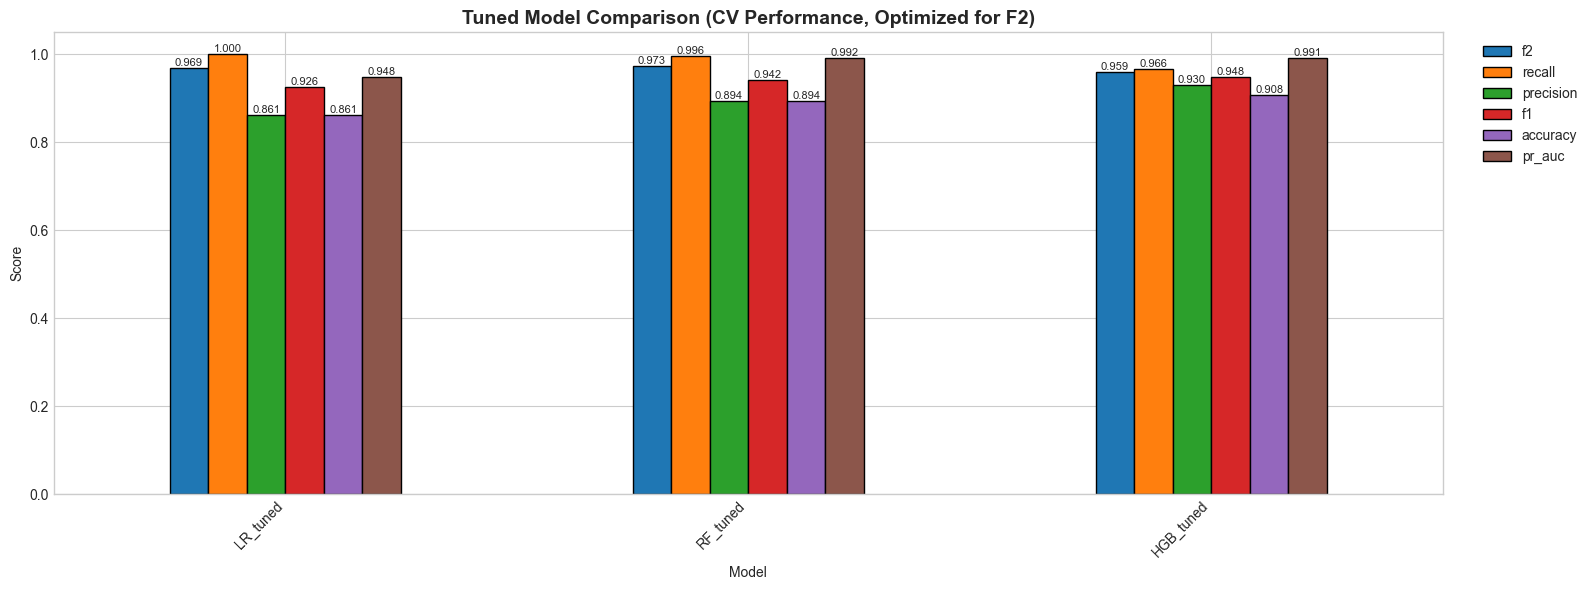

In [14]:
# Compare tuned models (F2 as primary metric)
tuned_comparison = compare_models(
    cv_comparison_data,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Tuned Model Comparison (CV Performance, Optimized for F2)',
    save_path='images/fp_tuned_comparison.png'
)

### 4.5 Top Hyperparameter Combinations

Review the top performing hyperparameter combinations for each model to guide future grid adjustments.

In [15]:
def get_top_hyperparameter_runs(search_object, model_name, n_top=10, metric='f2'):
    """Extract top n hyperparameter combinations from a GridSearchCV object."""
    cv_results = search_object.cv_results_
    
    # Get parameter names (remove 'param_' prefix)
    param_names = [k.replace('param_', '') for k in cv_results.keys() if k.startswith('param_')]
    
    # Build dataframe with all results
    results_data = []
    for i in range(len(cv_results['mean_test_' + metric])):
        row = {
            'rank': cv_results['rank_test_' + metric][i],
            f'val_{metric}': cv_results['mean_test_' + metric][i],
            f'val_{metric}_std': cv_results['std_test_' + metric][i],
            f'train_{metric}': cv_results['mean_train_' + metric][i],
            'gap': cv_results['mean_train_' + metric][i] - cv_results['mean_test_' + metric][i],
        }
        # Add parameter values
        for param in param_names:
            row[param] = cv_results[f'param_{param}'][i]
        results_data.append(row)
    
    df = pd.DataFrame(results_data)
    df = df.sort_values('rank').head(n_top)
    
    return df, param_names

# Display top 10 hyperparameter combinations for each model
for model_name, search in tuned_models.items():
    print("=" * 80)
    print(f"TOP 10 HYPERPARAMETER COMBINATIONS: {model_name}")
    print("=" * 80)
    
    top_df, param_names = get_top_hyperparameter_runs(search, model_name, n_top=10, metric='f2')
    
    # Display with formatted output
    display_cols = ['rank', 'val_f2', 'val_f2_std', 'train_f2', 'gap'] + param_names
    print(top_df[display_cols].to_string(index=False))
    print()
    
    # Also show best parameters explicitly
    print(f"Best parameters: {search.best_params_}")
    print()

TOP 10 HYPERPARAMETER COMBINATIONS: LR_tuned
 rank   val_f2  val_f2_std  train_f2           gap    C class_weight penalty solver
    1 0.968839    0.000388  0.968839 -1.166750e-07 0.01         None      l2  lbfgs
    1 0.968839    0.000388  0.968839 -1.166750e-07 0.10         None      l2  lbfgs

Best parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}

TOP 10 HYPERPARAMETER COMBINATIONS: RF_tuned
 rank   val_f2  val_f2_std  train_f2      gap       class_weight  max_depth  min_samples_leaf  min_samples_split  n_estimators
    1 0.973410    0.002138       1.0 0.026590 balanced_subsample        NaN                 1                  2           200
    1 0.973410    0.002138       1.0 0.026590 balanced_subsample       20.0                 1                  2           200
    3 0.973135    0.003523       1.0 0.026865 balanced_subsample        NaN                 1                  5           200
    3 0.973135    0.003523       1.0 0.026865 balanced_subsam

## 5. Overfitting Analysis

Analyze the gap between training and validation performance using CV results. This analysis uses only training data (through cross-validation) and does NOT use the held-out test set.

**Key insight**: In GridSearchCV, `mean_train_*` scores are computed on the training folds and `mean_test_*` scores are computed on the validation folds. A large gap indicates overfitting.

In [16]:
# Get summary of train-validation gaps for all tuned models
gap_summary_df = get_gap_summary(tuned_models, metric='f2')


TRAIN-VALIDATION GAP SUMMARY (F2)

Gap thresholds: Warning >= 5%, Severe >= 10%

--------------------------------------------------------------------------------

✓ LR_tuned:
    Train f2: 0.9688 (+/- 0.0002)
    Val f2:   0.9688 (+/- 0.0004)
    Gap:        -0.0000 (-0.0%) [Good]

✓ RF_tuned:
    Train f2: 1.0000 (+/- 0.0000)
    Val f2:   0.9734 (+/- 0.0021)
    Gap:        0.0266 (2.7%) [Good]

✓ HGB_tuned:
    Train f2: 1.0000 (+/- 0.0000)
    Val f2:   0.9588 (+/- 0.0113)
    Gap:        0.0412 (4.1%) [Good]




Random Forest - Train-Validation Gap Analysis

Metric: f2
  Training score:   1.0000
  Validation score: 0.9734
  Gap:              0.0266 (2.7%)

Diagnosis: Good fit
  (Warning threshold: 5%, Severe threshold: 10%)
  Figure saved: images/fp_rf_train_val_gap.png


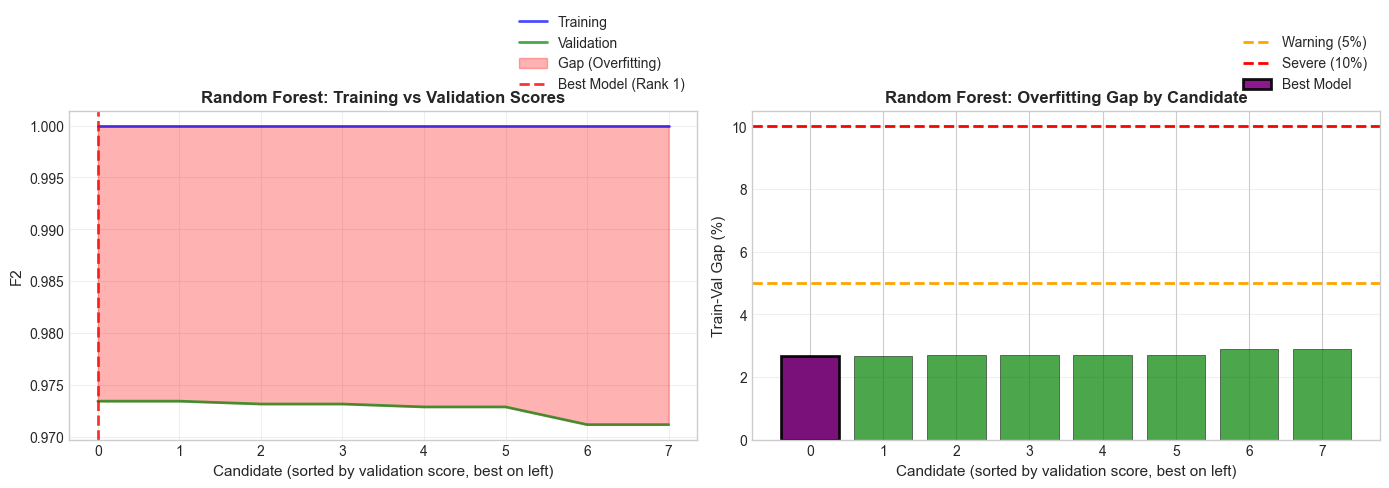

In [17]:
# Detailed train-validation gap analysis for Random Forest
# Shows diagnosis (Good fit / Moderate / Severe overfitting) and recommendations
rf_gap_result = analyze_cv_train_val_gap(
    rf_search, 
    metric='f2',
    model_name='Random Forest',
    save_path='images/fp_rf_train_val_gap.png'
)

### 5.2 RF Performance vs n_estimators

Analyze how Random Forest performance changes with the number of trees, using optimal parameters from tuning.

In [18]:
# Create a grid varying only n_estimators while keeping other RF params at optimal values
best_rf_params = rf_search.best_params_.copy()
n_estimators_values = [50, 100, 150, 200, 250, 300]

# Build param grid with all params fixed except n_estimators
rf_iteration_param_grid = {
    'n_estimators': n_estimators_values,
    'max_depth': [best_rf_params.get('max_depth')],
    'min_samples_split': [best_rf_params.get('min_samples_split', 2)],
    'min_samples_leaf': [best_rf_params.get('min_samples_leaf', 1)],
    'class_weight': [best_rf_params.get('class_weight', 'balanced')],
}

# Run grid search with this restricted grid
rf_iteration_search = create_search_object(
    search_type='grid',
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_iteration_param_grid,
    cv=cv,
    refit='f2'
)

rf_iteration_search, _, _ = tune_with_logging(
    rf_iteration_search, X_trainval, y_trainval,
    model_name='rf_iterations'
)


HYPERPARAMETER TUNING: rf_iterations
Total parameter combinations: 6
Cross-validation folds: 3
Total fits: 18
Log file: models/logs/rf_iterations_20251221_212626.log

Tuning complete!
Best score (f2): 0.9740
Results saved to: models/logs/rf_iterations_20251221_212626_cv_results.csv



Random Forest - n_estimators Performance Analysis

Metric: f2

Optimal n_estimators: 300
  Training F2:   1.0000
  Validation F2: 0.9740
  Gap:               0.0260 (2.6%)

Tuned n_estimators from hyperparameter search: 200
  Training F2:   1.0000
  Validation F2: 0.9734
  Gap:               0.0266 (2.7%)
  Figure saved: images/fp_rf_iteration_performance.png


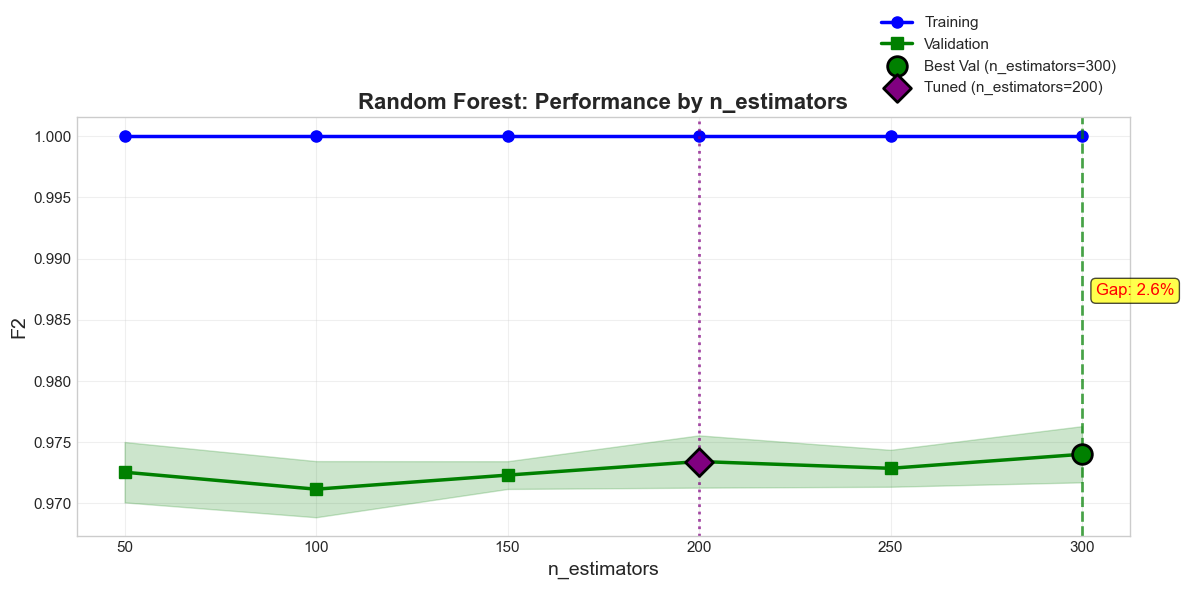

In [19]:
# Analyze performance across n_estimators values with confidence bands
# Shows train/val scores with gap annotation at optimal point
iteration_result = analyze_iteration_performance(
    rf_iteration_search,
    param_name='n_estimators',
    metric='f2',
    tuned_value=best_rf_params.get('n_estimators', 200),
    model_name='Random Forest',
    save_path='images/fp_rf_iteration_performance.png'
)

## 6. Final Model Selection

Select the best model based on CV F2 score and save artifacts for final evaluation in fp3.

**Note:** Test set evaluation, threshold optimization, and deployment are performed in fp3_model_evaluation_deployment.ipynb.

In [20]:
# Select best model based on CV F2
best_model_name, best_model_metrics = get_best_model(tuned_comparison, 'f2')
print(f"Selected model: {best_model_name}")
print(f"CV F2: {best_model_metrics['f2']:.4f} (primary metric)")
print(f"CV Recall: {best_model_metrics['recall']:.4f}")
print(f"CV Precision: {best_model_metrics['precision']:.4f}")

# Get the best fitted model
best_search = tuned_models[best_model_name]
best_model = best_search.best_estimator_

# Save best classifier for fp3
classifier_path = MODELS_DIR / 'fp_best_classifier.joblib'
joblib.dump(best_model, classifier_path)
print(f"\nBest classifier saved to: {classifier_path}")


Best model by f2: RF_tuned
Score: 0.9734
Selected model: RF_tuned
CV F2: 0.9734 (primary metric)
CV Recall: 0.9956
CV Precision: 0.8937

Best classifier saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_best_classifier.joblib


In [21]:
# Save CV metrics for comparison in fp3
cv_metrics = {
    'model_name': best_model_name,
    'cv_f2': float(best_model_metrics['f2']),
    'cv_recall': float(best_model_metrics['recall']),
    'cv_precision': float(best_model_metrics['precision']),
    'cv_f1': float(best_model_metrics['f1']),
    'cv_accuracy': float(best_model_metrics['accuracy']),
    'cv_pr_auc': float(best_model_metrics['pr_auc']),
    'best_params': best_search.best_params_,
    'transformer_method': transformer.method,
    'n_folds': N_FOLDS,
}

cv_metrics_path = MODELS_DIR / 'fp_cv_metrics.json'
with open(cv_metrics_path, 'w') as f:
    json.dump(cv_metrics, f, indent=2)
print(f"CV metrics saved to: {cv_metrics_path}")

CV metrics saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_cv_metrics.json


In [22]:
print("=" * 60)
print("FP2 NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"Feature Method: {transformer.method}")
print(f"\nCV Performance ({N_FOLDS}-fold):")
print(f"  F2 Score:  {best_model_metrics['f2']:.4f}")
print(f"  Recall:    {best_model_metrics['recall']:.4f}")
print(f"  Precision: {best_model_metrics['precision']:.4f}")
print(f"\nBest Hyperparameters:")
for param, value in best_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nSaved Artifacts for fp3:")
print(f"  - {classifier_path}")
print(f"  - {cv_metrics_path}")
print(f"\nNext: Run fp3_model_evaluation_deployment.ipynb for:")
print(f"  - Final test set evaluation")
print(f"  - Threshold optimization")
print(f"  - Pipeline export for deployment")
print("=" * 60)

FP2 NOTEBOOK SUMMARY

Best Model: RF_tuned
Feature Method: sentence_transformer_ner

CV Performance (3-fold):
  F2 Score:  0.9734
  Recall:    0.9956
  Precision: 0.8937

Best Hyperparameters:
  class_weight: balanced_subsample
  max_depth: 20
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Saved Artifacts for fp3:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_best_classifier.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_cv_metrics.json

Next: Run fp3_model_evaluation_deployment.ipynb for:
  - Final test set evaluation
  - Threshold optimization
  - Pipeline export for deployment
